# A Sentiment Analysis of MLB Performance
### ADS-509 Final Project Team 11

# Libraries

In [1]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install tqdm

In [85]:
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
import re
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

The first step in our effort is to scrape blog post text from the mlbtraderumors.com website.  This posts include text, dates posted, and the authors name.  We will scrape this information and store it in a dataframe that we can use to start our text analysis.

# Functions

In [3]:
#Scrapes blog posts off of website
def scrape_website(url, file_path):
    # Send a GET request to the website
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the news article elements
    articles = soup.find_all("article")

    # Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    # Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            # Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            # Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            # Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            # Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            # Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    # Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)

    # Drop rows without content
    df.dropna()

    return df

#Initial Text Data Processing
def processing(df):
    #change the Date column to a datetime object
    df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')
    print(df.dtypes)

    print('DataFrame has', len(df), 'rows.')

    # Check for missing values
    print(df.isna().sum())

    #drop missing values
    df = df.dropna()
    
    print('The DataFrame now has', len(df), 'rows, after dropping null text rows.')
    return df

#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

#Identify noise in the text data:
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

# Plot the text length metrics
def plot_analysis(df):
    # Extract the month from the date and create a new column
    df['Month'] = df['Date'].dt.month

    # Plot the average post length
    plt.figure(figsize=(6, 2))
    df.groupby('Month').agg({'length': 'mean'}) \
        .plot(title="Avg. Post Length", ylim=(0, 500))
    plt.show()

    # Plot the post length histogram
    plt.figure(figsize=(8, 2))
    df['length'].plot(kind='hist', bins=30)
    plt.show()

    # Create a new column for title length
    df['Title_length'] = df['Title'].str.len()

    # Plot the title length box plot
    plt.figure(figsize=(8, 1))
    df['Title_length'].plot(kind='box', vert=False)
    plt.show()

    # Plot the post length box plot
    plt.figure(figsize=(8, 1))
    df['length'].plot(kind='box', vert=False)
    plt.show()

    #Word Frequency function:
    
#count words function for frequency analysis
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    #Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #Create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    #Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

#processes team data, creates binary success variable, and plots descriptive information
def team_info(df):
    # Use data only back to 2005
    df = df[df['Year'] > 2004]

    # Remove the dollar sign and comma from Est. Payroll column
    df['Est. Payroll'] = df['Est. Payroll'].replace({'\$': '', ',': ''}, regex=True)

    # Convert Est. Payroll to float
    df['Est. Payroll'] = df['Est. Payroll'].astype(float)

    # Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
    df['success'] = (df['W'] / (df['W'] + df['L']) >= 0.5).astype(int)

    # Count the number of successes and failures
    success_counts = df['success'].value_counts()

    # Create a bar plot
    plt.bar(success_counts.index, success_counts.values)
    plt.xticks(success_counts.index, ['Failure', 'Success'])
    plt.xlabel('Success')
    plt.ylabel('Count')
    plt.title('Success Counts')
    plt.show()

    # Plotting descriptive data on teams
    plt.figure(figsize=(10, 6))

    # Plotting Attendance over the years
    plt.plot(df['Year'].values, df['Attendance'].values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Attendance')
    plt.title('Home Attendance Per year')
    plt.show()

    # Plotting Wins over the years
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'].values, df['W'].values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Wins')
    plt.title('Wins per Year')
    plt.show()

    # Plotting Payroll over the years
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'].values, df['Est. Payroll'].values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Payroll')
    plt.title('Payroll of Washington Nationals over the years')
    plt.show()

    # Select numeric columns for correlation analysis
    numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
    numeric_df = df[numeric_cols]

    # Correlation matrix
    correlation = numeric_df.corr()

    # Plotting the correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # Return the modified dataframe
    return df




# Washington Nationals Data Collection and Cleaning

In [4]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/washington-nationals?show=all"
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/mlbtraderumors_washington_nationals_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
df = scrape_website(url, file_path)
df.head()

,Title,Author,Date,Content
0,"Nationals Select Derek Hill, Place Victor Robl...",Steve Adams,"June 21, 2023",The Nationals have selected the contract of ou...
1,"Nationals, Orioles Reach Settlement On 2012-16...",Anthony Franco,"June 20, 2023",The Nationals and Orioles have settled their d...
2,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,"June 15, 2023",Veteran lefty Sean Doolittle was transferred f...
3,Nationals Release Erasmo Ramírez,Darragh McDonald,"June 9, 2023",The Nationals have released right-hander Erasm...
4,Best Deadline Rental Returns In Recent History...,Darragh McDonald,"June 8, 2023",With the trade deadline now less than two mont...


In [5]:
df = processing(df)
df.head()

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object
DataFrame has 1030 rows.
Title       0
Author      0
Date       30
Content     0
dtype: int64
The DataFrame now has 1000 rows, after dropping null text rows.


,Title,Author,Date,Content
0,"Nationals Select Derek Hill, Place Victor Robl...",Steve Adams,2023-06-21,The Nationals have selected the contract of ou...
1,"Nationals, Orioles Reach Settlement On 2012-16...",Anthony Franco,2023-06-20,The Nationals and Orioles have settled their d...
2,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred f...
3,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,The Nationals have released right-hander Erasm...
4,Best Deadline Rental Returns In Recent History...,Darragh McDonald,2023-06-08,With the trade deadline now less than two mont...


## Import data on the washington nationals from baseball-reference.com

https://www.baseball-reference.com/teams/WSN/attend.shtml

In [6]:
import pandas as pd

# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/WSN/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/attendance_data.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)


Data saved to C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/attendance_data.csv


In [7]:
path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/"

nats_df = pd.DataFrame(pd.read_csv(path + 'attendance_data.csv'))
nats_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,28,45,5,NaN,848634.0,21760.0,12th of 15,"$98,376,067",96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,"$125,051,666",96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,"$172,370,147",96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,"$172,237,283",99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,"$203,016,595",102,102,Nationals Park


<ipython-input-3-39896adaab3c>:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].replace({'\$': '', ',': ''}, regex=True)
<ipython-input-3-39896adaab3c>:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].astype(float)
<ipython-input-3-39896adaab3c>:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

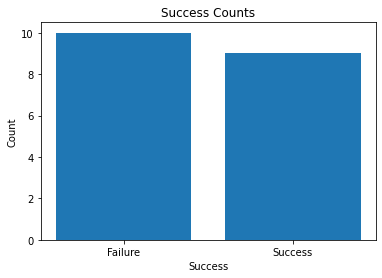

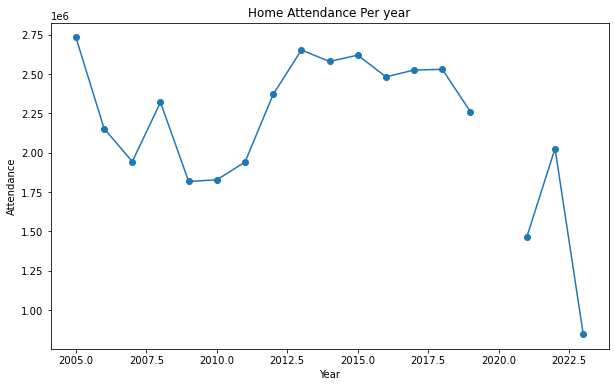

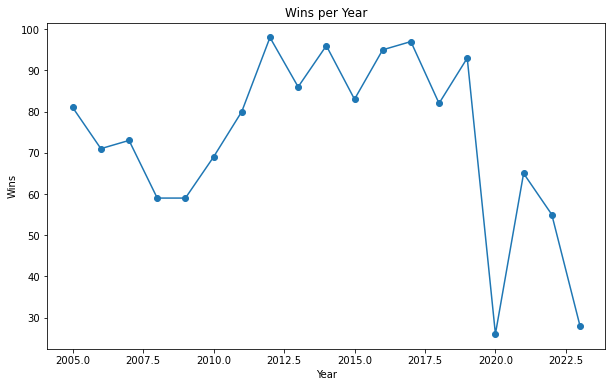

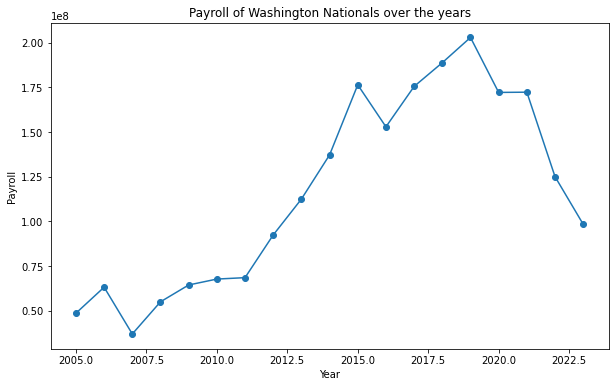

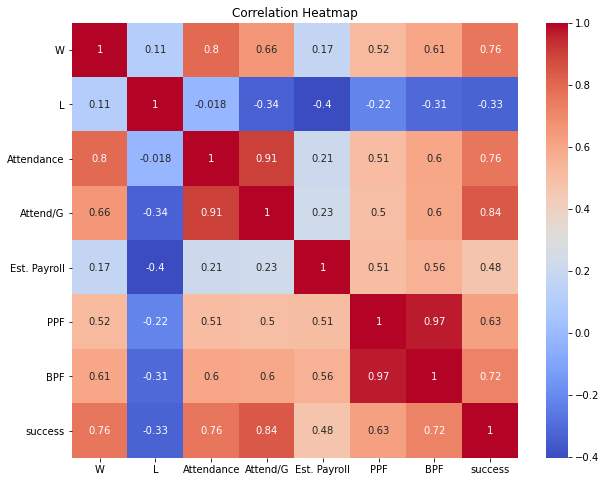

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Washington Nationals,NL East,28,45,5,NaN,848634.0,21760.0,12th of 15,98376067.0,96,94,Nationals Park,0
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,125051666.0,96,94,Nationals Park,0
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,172370147.0,96,95,Nationals Park,0
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,172237283.0,99,99,Nationals Park,0
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,203016595.0,102,102,Nationals Park,1


In [8]:
nats_df = team_info(nats_df)
nats_df.head()

Add column to for whether blog post occured in a successful year or not.

In [9]:
# Extract the year from the "Date" column in df DataFrame
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Merge df and nats_df DataFrames on the "Year" column
merged_df = pd.merge(df, nats_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_df['Year_Successful'] = merged_df['success'].fillna(0).astype(int)

merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,"Nationals Select Derek Hill, Place Victor Robl...",Steve Adams,2023-06-21,The Nationals have selected the contract of ou...,2023,0,0
1,"Nationals, Orioles Reach Settlement On 2012-16...",Anthony Franco,2023-06-20,The Nationals and Orioles have settled their d...,2023,0,0
2,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred f...,2023,0,0
3,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,The Nationals have released right-hander Erasm...,2023,0,0
4,Best Deadline Rental Returns In Recent History...,Darragh McDonald,2023-06-08,With the trade deadline now less than two mont...,2023,0,0


In [10]:
len(merged_df)

1000

## Cleaning the Data

Here we will look for any noise in the data, and also calculate the impurity:

In [11]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_df['impurity'] = merged_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
603,The Nationals announced they’ve selected the contract of right-hander Steven Fuentes. The 23-yea...,0.003333
561,"Kyle Schwarber is now a member of the Washington Nationals, in no small part because of Nats man...",0.003155
567,The Nationals accomplished a big part of their winter to-do list when they acquired Josh Bell fr...,0.002786


The above shows the highest impurity levels for this data set.  Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

Now we'll do some character normalization and tokenization

In [12]:
# Apply normalization to the "Contents" column
merged_df["Contents_Normalized"] = merged_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_df[["Content", "Contents_Normalized"]].head()


,Content,Contents_Normalized
0,"The Nationals have selected the contract of outfielder Derek Hill from Triple-A Rochester, per a...","[nation, select, contract, outfield, derek, hill, triplea, rochest, per, team, announc, correspo..."
1,"The Nationals and Orioles have settled their dispute regarding MASN rights fees between 2012-16,...","[nation, oriol, settl, disput, regard, masn, right, fee, first, report, chelsea, jane, ben, stra..."
2,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig..."
3,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...","[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,..."
4,"With the trade deadline now less than two months away, we at MLBTR are setting our sights backwa...","[trade, deadlin, less, two, month, away, mlbtr, set, sight, backward, bit, highlight, past, trad..."


In [13]:
merged_df['length'] = merged_df['Contents_Normalized'].str.len()
merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,"Nationals Select Derek Hill, Place Victor Robles On Injured List",Steve Adams,2023-06-21,"The Nationals have selected the contract of outfielder Derek Hill from Triple-A Rochester, per a...",2023,0,0,0.000000,"[nation, select, contract, outfield, derek, hill, triplea, rochest, per, team, announc, correspo...",239
1,"Nationals, Orioles Reach Settlement On 2012-16 MASN Rights Fees",Anthony Franco,2023-06-20,"The Nationals and Orioles have settled their dispute regarding MASN rights fees between 2012-16,...",2023,0,0,0.000000,"[nation, oriol, settl, disput, regard, masn, right, fee, first, report, chelsea, jane, ben, stra...",274
2,"Sean Doolittle Completes Rehab Assignment, Heads To Triple-A Rochester",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,2023,0,0,0.000000,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig...",60
3,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...",2023,0,0,0.000000,"[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,...",130
4,"Best Deadline Rental Returns In Recent History, #8: Nationals Get Everyday Outfielder For Jon Le...",Darragh McDonald,2023-06-08,"With the trade deadline now less than two months away, we at MLBTR are setting our sights backwa...",2023,0,0,0.000441,"[trade, deadlin, less, two, month, away, mlbtr, set, sight, backward, bit, highlight, past, trad...",607


## Look at descriptive stats for text in dataframe

<Figure size 432x144 with 0 Axes>

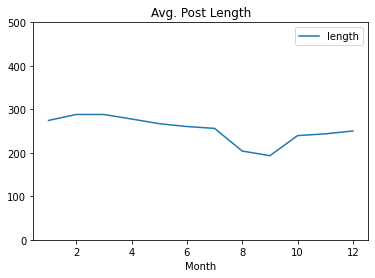

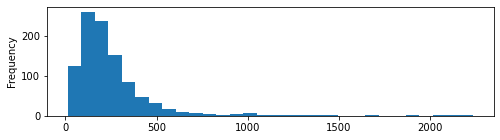

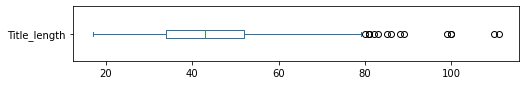

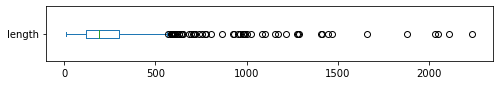

In [14]:
plot_analysis(merged_df)

#### Here we do a word count/frequency analysis

In [15]:
freq_df = count_words(merged_df)
freq_df.head(5)

,freq
token,
season,3105
nation,2756
year,2408
leagu,1806
nat,1611


In [16]:
#How many tokens are in the df?
len(freq_df)

6443

In [17]:
# top words with 10+ characters
count_words(merged_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)



,freq
token,
Washington,1262
appearances,621
organization,386
outfielder,259
arbitration,257


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

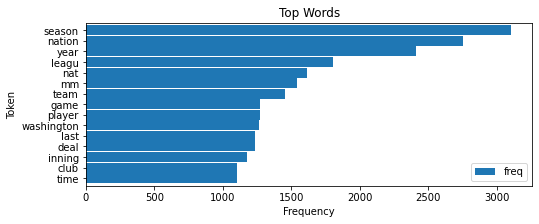

In [18]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# San Diego Padres Data Collection and Cleaning

In [19]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/san-diego-padres?show=all"
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/mlbtraderumors_padres_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
sd_df = scrape_website(url, file_path)
sd_df.head()

,Title,Author,Date,Content
0,A’s Claim Angel Felipe,Steve Adams,"June 21, 2023","The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann..."
1,Padres Designate Nabil Crismatt For Assignment,Darragh McDonald,"June 20, 2023","The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with..."
2,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,"June 19, 2023","Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ..."
3,Seth Lugo To Return Tuesday,Nick Deeds,"June 18, 2023","The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur..."
4,Padres Select Preston Tucker,Nick Deeds,"June 18, 2023","In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b..."


In [20]:
sd_df = processing(sd_df)
sd_df.head()

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object
DataFrame has 1030 rows.
Title       0
Author      0
Date       30
Content     0
dtype: int64
The DataFrame now has 1000 rows, after dropping null text rows.


,Title,Author,Date,Content
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann..."
1,Padres Designate Nabil Crismatt For Assignment,Darragh McDonald,2023-06-20,"The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with..."
2,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ..."
3,Seth Lugo To Return Tuesday,Nick Deeds,2023-06-18,"The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur..."
4,Padres Select Preston Tucker,Nick Deeds,2023-06-18,"In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b..."


## Import data on the San Diego Padres from baseball-reference.com

https://www.baseball-reference.com/teams/SDP/attend.shtml

In [21]:
import pandas as pd

# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/SDP/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/sdp_attendance_data.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)




Data saved to C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/sdp_attendance_data.csv


In [22]:
path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/"

pads_df = pd.DataFrame(pd.read_csv(path + 'sdp_attendance_data.csv'))
pads_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,San Diego Padres,NL West,35,39,4,NaN,1549480.0,39730.0,2nd of 15,"$234,100,139",93,93,Petco Park
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,"$173,600,824",93,93,Petco Park
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,"$151,984,286",92,92,Petco Park
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,"$141,953,667",93,93,Petco Park
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,"$90,260,767",95,94,Petco Park


<ipython-input-3-39896adaab3c>:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].replace({'\$': '', ',': ''}, regex=True)
<ipython-input-3-39896adaab3c>:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].astype(float)
<ipython-input-3-39896adaab3c>:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

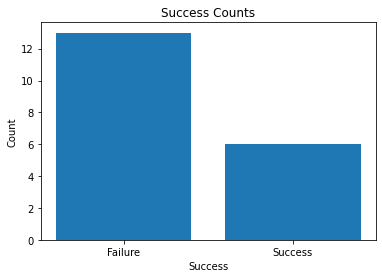

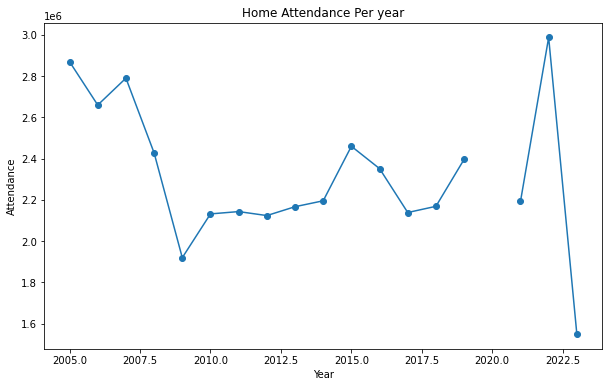

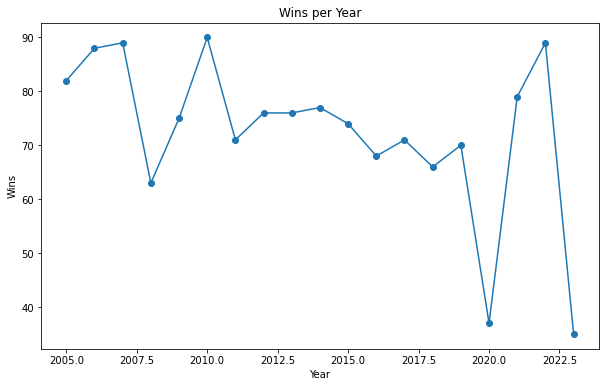

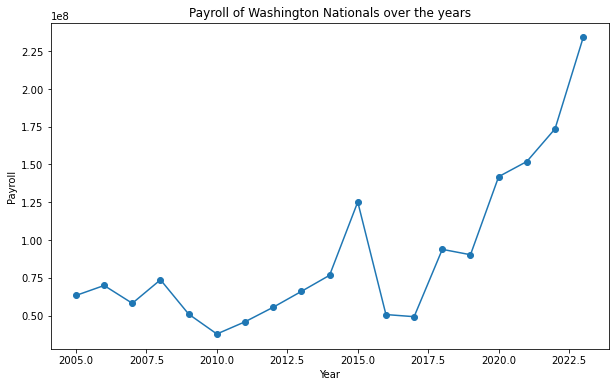

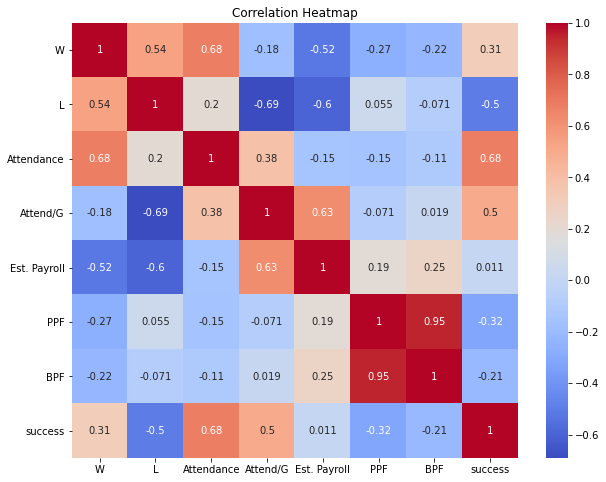

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,San Diego Padres,NL West,35,39,4,NaN,1549480.0,39730.0,2nd of 15,234100139.0,93,93,Petco Park,0
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,173600824.0,93,93,Petco Park,1
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,151984286.0,92,92,Petco Park,0
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,141953667.0,93,93,Petco Park,1
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,90260767.0,95,94,Petco Park,0


In [23]:
pads_df = team_info(pads_df)
pads_df.head()

Here we will add the "success" column to the dataframe with the text.  This shows whether a blog post was associated with a successful year or not.

In [24]:
# Extract the year from the "Date" column in df DataFrame
sd_df['Year'] = pd.to_datetime(sd_df['Date']).dt.year

# Merge df and pads_df DataFrames on the "Year" column
merged_sd_df = pd.merge(sd_df, pads_df[['Year', 'success']], on='Year', how='left')

# Add a new column 'Year_Successful' based on 'success' column
merged_sd_df['Year_Successful'] = merged_sd_df['success'].fillna(0).astype(int)

merged_sd_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0
1,Padres Designate Nabil Crismatt For Assignment,Darragh McDonald,2023-06-20,"The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with...",2023,0,0
2,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...",2023,0,0
3,Seth Lugo To Return Tuesday,Nick Deeds,2023-06-18,"The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur...",2023,0,0
4,Padres Select Preston Tucker,Nick Deeds,2023-06-18,"In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b...",2023,0,0


In [25]:
len(merged_sd_df)

1000

## Cleaning the Data

In [26]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_sd_df['impurity'] = merged_sd_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_sd_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
59,"Jake Cronenworth signed a seven-year, $80MM extension with the Padres, so what does that mean fo...",0.009479
129,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
840,What is the role of the Players’ Union in the Astros’ sign-stealing scandal? Why are the Padres ...,0.003484


The above shows the highest impurity levels for this data set.  Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

Now we'll do some character normalization and tokenization

In [27]:
# Apply normalization to the "Contents" column
merged_sd_df["Contents_Normalized"] = merged_sd_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_sd_df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...","[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple..."
1,"The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with...","[padr, announc, righthand, seth, lugo, reinstat, injur, list, fellow, righti, nabil, crismatt, d..."
2,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...","[veteran, infield, jo, iglesia, opt, minor, leagu, deal, padr, report, mark, feinsand, mlbcom, t..."
3,"The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur...","[padr, expect, welcom, righthand, seth, lugo, back, fold, tuesday, figur, start, giant, san, fra..."
4,"In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b...","[somewhat, unusu, move, padr, select, contract, outfield, preston, tucker, promptli, place, day,..."


In [28]:
merged_sd_df['length'] = merged_sd_df['Contents_Normalized'].str.len()
merged_sd_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0,0.0,"[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple...",182
1,Padres Designate Nabil Crismatt For Assignment,Darragh McDonald,2023-06-20,"The Padres announced that right-hander Seth Lugo has been reinstated from the injured list, with...",2023,0,0,0.0,"[padr, announc, righthand, seth, lugo, reinstat, injur, list, fellow, righti, nabil, crismatt, d...",147
2,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...",2023,0,0,0.0,"[veteran, infield, jo, iglesia, opt, minor, leagu, deal, padr, report, mark, feinsand, mlbcom, t...",181
3,Seth Lugo To Return Tuesday,Nick Deeds,2023-06-18,"The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur...",2023,0,0,0.0,"[padr, expect, welcom, righthand, seth, lugo, back, fold, tuesday, figur, start, giant, san, fra...",76
4,Padres Select Preston Tucker,Nick Deeds,2023-06-18,"In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b...",2023,0,0,0.0,"[somewhat, unusu, move, padr, select, contract, outfield, preston, tucker, promptli, place, day,...",306


## Look at descriptive stats for text in dataframe

<Figure size 432x144 with 0 Axes>

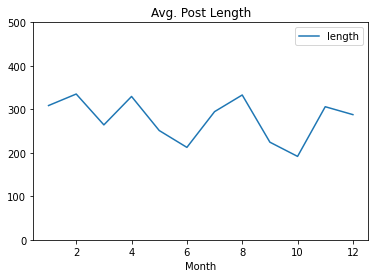

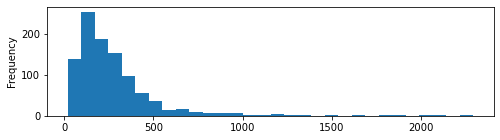

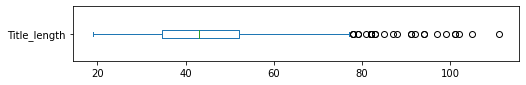

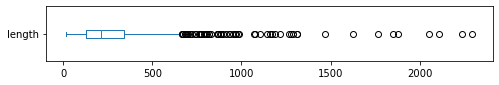

In [29]:
plot_analysis(merged_sd_df)

Here we will look at the word frequency using our count words function:

In [30]:
freq_df = count_words(merged_sd_df)
freq_df.head(5)

,freq
token,
padr,3768
season,3481
year,2700
mm,2362
leagu,1829


In [31]:
#How many tokens are in the df?
len(freq_df)

6518

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

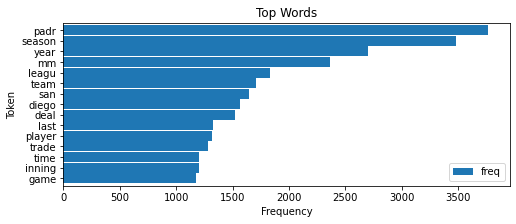

In [32]:
# top words with 10+ characters
count_words(merged_sd_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Oakland Athletics Data Collection and Cleaning

In [33]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/oakland-athletics?show=all"
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/mlbtraderumors_athletics_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
oa_df = scrape_website(url, file_path)
oa_df.head()

,Title,Author,Date,Content
0,A’s Preparing Application To MLB For Relocation,Anthony Franco,"June 21, 2023",The Athletics have begun the process to officially apply to Major League Baseball for relocation...
1,A’s Claim Angel Felipe,Steve Adams,"June 21, 2023","The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann..."
2,Athletics Select Yacksel Ríos,Darragh McDonald,"June 20, 2023",The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...
3,Dick Hall Passes Away,Darragh McDonald,"June 19, 2023",The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...
4,A’s Acquire Yacksel Rios,Nick Deeds,"June 18, 2023","6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact..."


In [34]:
oa_df = processing(oa_df)
oa_df.head()

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object
DataFrame has 1030 rows.
Title       0
Author      0
Date       30
Content     0
dtype: int64
The DataFrame now has 1000 rows, after dropping null text rows.


,Title,Author,Date,Content
0,A’s Preparing Application To MLB For Relocation,Anthony Franco,2023-06-21,The Athletics have begun the process to officially apply to Major League Baseball for relocation...
1,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann..."
2,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...
3,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...
4,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact..."


## Import data on the Oakland Athletics from baseball-reference.com

https://www.baseball-reference.com/teams/OAK/attend.shtml

In [35]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/OAK/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/athletics_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)



Data saved to C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/athletics_statistics.csv


In [36]:
path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/"

athletics_df = pd.DataFrame(pd.read_csv(path + 'athletics_statistics.csv'))
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,57,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",94,92,Oakland Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum


<ipython-input-3-39896adaab3c>:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].replace({'\$': '', ',': ''}, regex=True)
<ipython-input-3-39896adaab3c>:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].astype(float)
<ipython-input-3-39896adaab3c>:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

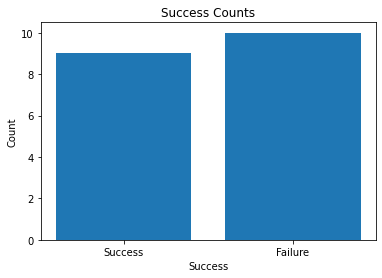

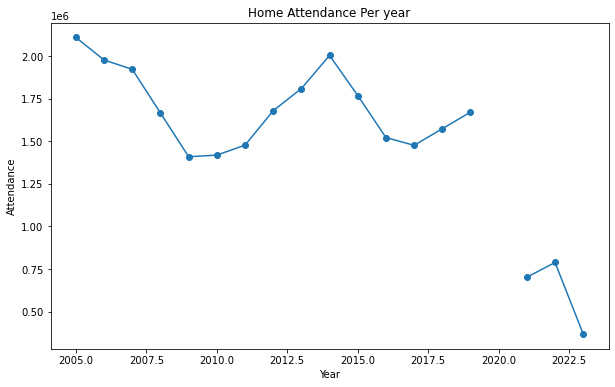

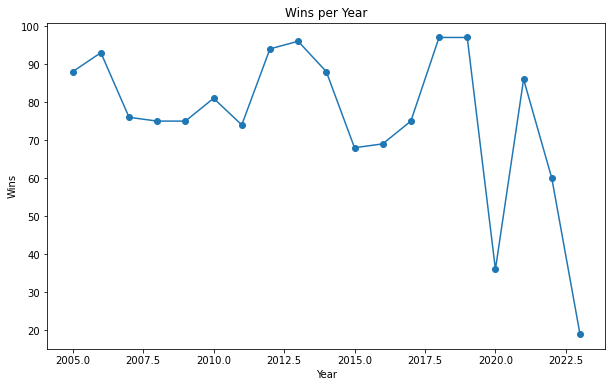

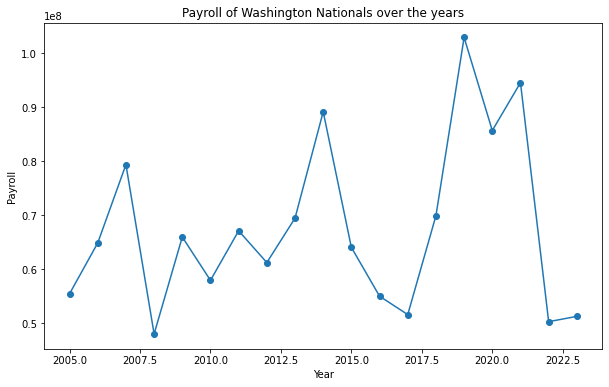

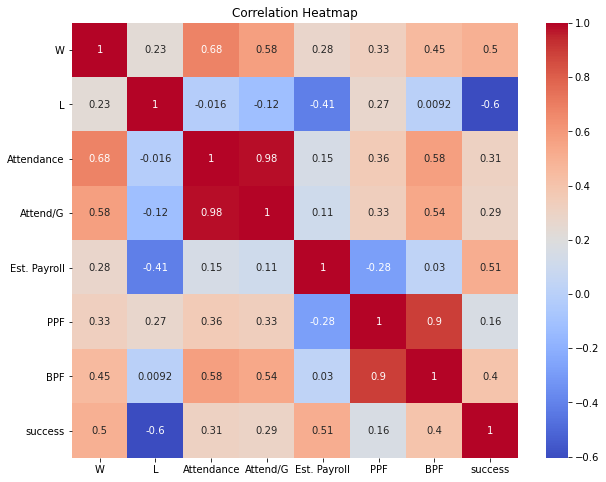

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Oakland Athletics,AL West,19,57,5,NaN,368146.0,9688.0,15th of 15,51230000.0,94,92,Oakland Coliseum,0
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334.0,95,93,RingCentral Coliseum,0
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834.0,95,95,RingCentral Coliseum,1
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333.0,94,96,Oakland-Alameda County Coliseum,1
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833.0,93,94,Oakland-Alameda County Coliseum,1


In [37]:
athletics_df = team_info(athletics_df)
athletics_df.head()

### Add column to analyze whether blog post occurred in a successful year or not.

In [38]:
#Extract the year from the "Date" column in df DataFrame
oa_df['Year'] = pd.to_datetime(oa_df['Date']).dt.year

#Merge df and athletics_df DataFrames on the "Year" column
merged_oa_df = pd.merge(oa_df, athletics_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_oa_df['Year_Successful'] = merged_oa_df['success'].fillna(0).astype(int)

merged_oa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,A’s Preparing Application To MLB For Relocation,Anthony Franco,2023-06-21,The Athletics have begun the process to officially apply to Major League Baseball for relocation...,2023,0,0
1,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0
2,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,2023,0,0
3,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,2023,0,0
4,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...",2023,0,0


In [39]:
len(merged_oa_df)

1000

## Cleaning the Data

In [40]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_oa_df['impurity'] = merged_oa_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_oa_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
114,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
947,Left-handed pitching prospect Jesus Luzardo is drawing raves from both inside and outside the At...,0.004474
534,Kingston fit the mold of many of the Angels’ candidates — well-regarded younger executives who w...,0.003306


## Character Normalization and Tokenization

In [41]:
#Apply normalization to the "Contents" column
merged_oa_df["Contents_Normalized"] = merged_oa_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_oa_df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,The Athletics have begun the process to officially apply to Major League Baseball for relocation...,"[athlet, begun, process, offici, appli, major, leagu, basebal, reloc, write, mick, aker, la, veg..."
1,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...","[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple..."
2,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti..."
3,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ..."
4,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...","[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad..."


In [42]:
merged_oa_df['length'] = merged_oa_df['Contents_Normalized'].str.len()
merged_oa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,A’s Preparing Application To MLB For Relocation,Anthony Franco,2023-06-21,The Athletics have begun the process to officially apply to Major League Baseball for relocation...,2023,0,0,0.0,"[athlet, begun, process, offici, appli, major, leagu, basebal, reloc, write, mick, aker, la, veg...",134
1,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0,0.0,"[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple...",182
2,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,2023,0,0,0.0,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti...",179
3,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,2023,0,0,0.0,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ...",173
4,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...",2023,0,0,0.0,"[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad...",206


## Analyze descriptive statistics for text in dataframe.

<Figure size 432x144 with 0 Axes>

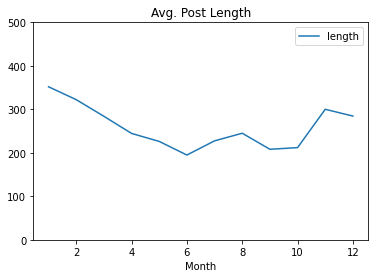

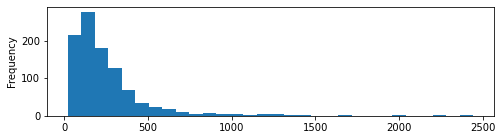

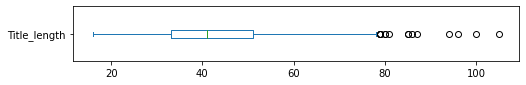

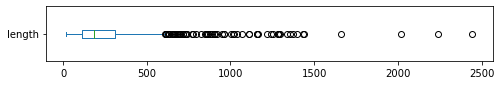

In [43]:
plot_analysis(merged_oa_df)

In [44]:
freq_df = count_words(merged_oa_df)
freq_df.head(5)

,freq
token,
season,3187
year,2292
leagu,1839
mm,1596
oakland,1572


In [45]:
#How many tokens are in the df?
len(freq_df)

6653

In [46]:
#Top words with 10+ characters
count_words(merged_oa_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)



,freq
token,
appearances,733
organization,374
arbitration,368
outfielder,316
assignment,272


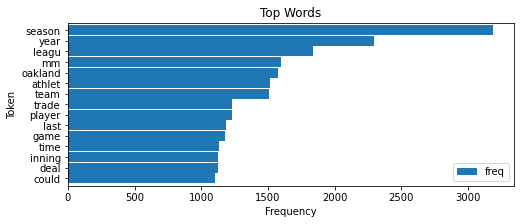

In [47]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

plt.show()

# Chicago White Sox Data Collection and Cleaning

In [48]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/chicago-white-sox?show=all"
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/mlbtraderumors_chicago_white_sox_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
cws_df = scrape_website(url, file_path)
cws_df.head()

,Title,Author,Date,Content
0,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,"June 21, 2023","The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
1,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,"June 21, 2023","Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ..."
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,"June 20, 2023","The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno..."
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,"June 19, 2023",The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,"June 16, 2023","The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ..."


In [49]:
cws_df = processing(cws_df)
cws_df.head()

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object
DataFrame has 1030 rows.
Title       0
Author      0
Date       30
Content     0
dtype: int64
The DataFrame now has 1000 rows, after dropping null text rows.


,Title,Author,Date,Content
0,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
1,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ..."
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno..."
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ..."


## Import Data on the Chicago White Sox from baseball-reference.com

https://www.baseball-reference.com/teams/CHW/attend.shtml

In [50]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/CHW/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/white_sox_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/white_sox_statistics.csv


In [51]:
path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/"

white_sox_df = pd.DataFrame(pd.read_csv(path + 'white_sox_statistics.csv'))
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,32,44,4,NaN,698040.0,18866.0,11th of 15,"$157,571,666",104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,"$163,958,334",103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,"$115,546,333",101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,"$119,066,333",100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,"$80,846,333",99,98,Guaranteed Rate Field


<ipython-input-3-39896adaab3c>:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].replace({'\$': '', ',': ''}, regex=True)
<ipython-input-3-39896adaab3c>:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].astype(float)
<ipython-input-3-39896adaab3c>:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

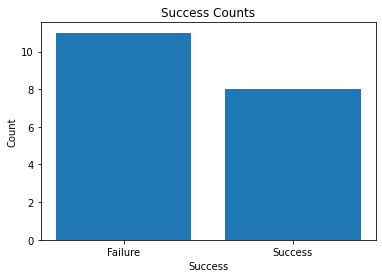

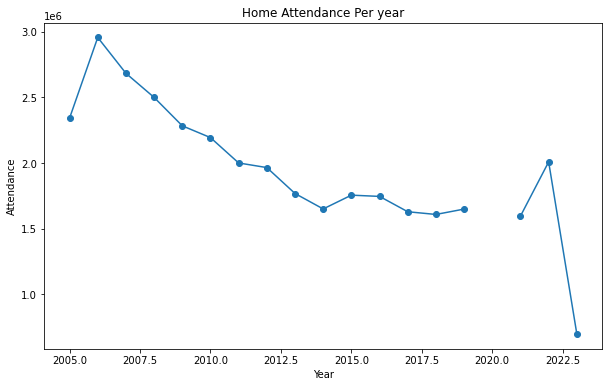

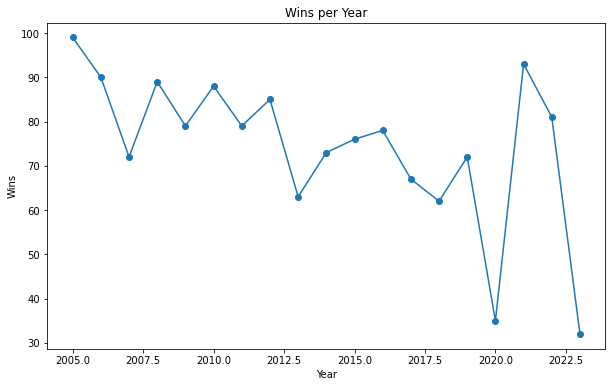

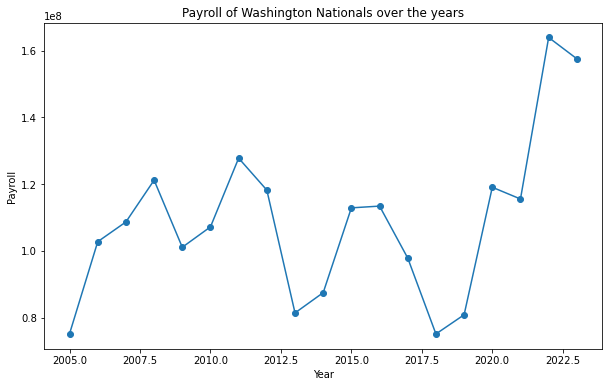

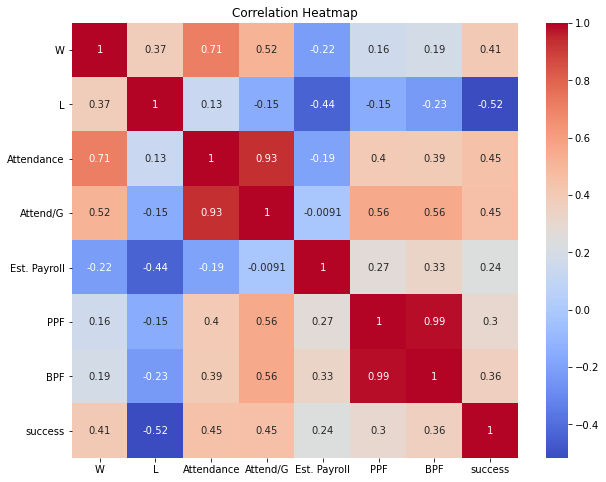

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Chicago White Sox,AL Central,32,44,4,NaN,698040.0,18866.0,11th of 15,157571666.0,104,104,Guaranteed Rate Field,0
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,163958334.0,103,103,Guaranteed Rate Field,1
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,115546333.0,101,102,Guaranteed Rate Field,1
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,119066333.0,100,100,Guaranteed Rate Field,1
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,80846333.0,99,98,Guaranteed Rate Field,0


In [52]:
white_sox_df = team_info(white_sox_df)
white_sox_df.head()

In [53]:
cws_df.head()

,Title,Author,Date,Content
0,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
1,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ..."
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno..."
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ..."


In [54]:
#Extract the year from the "Date" column in df DataFrame
cws_df['Year'] = pd.to_datetime(cws_df['Date']).dt.year

#Merge df and white_sox_df DataFrames on the "Year" column
merged_ws_df = pd.merge(cws_df, white_sox_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_ws_df['Year_Successful'] = merged_ws_df['success'].fillna(0).astype(int)

merged_ws_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023,0,0
1,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...",2023,0,0
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...",2023,0,0
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,2023,0,0
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...",2023,0,0


## Cleaning the Data

In [55]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_oa_df['impurity'] = merged_oa_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_oa_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
114,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
947,Left-handed pitching prospect Jesus Luzardo is drawing raves from both inside and outside the At...,0.004474
534,Kingston fit the mold of many of the Angels’ candidates — well-regarded younger executives who w...,0.003306


# Combine to one df for further analysis and modeling

In [56]:
comb_df = pd.concat([merged_df, merged_sd_df, merged_oa_df], ignore_index= True)
len(comb_df)

3000

In [57]:
comb_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length,Month,Title_length
0,"Nationals Select Derek Hill, Place Victor Robles On Injured List",Steve Adams,2023-06-21,"The Nationals have selected the contract of outfielder Derek Hill from Triple-A Rochester, per a...",2023,0,0,0.000000,"[nation, select, contract, outfield, derek, hill, triplea, rochest, per, team, announc, correspo...",239,6,64
1,"Nationals, Orioles Reach Settlement On 2012-16 MASN Rights Fees",Anthony Franco,2023-06-20,"The Nationals and Orioles have settled their dispute regarding MASN rights fees between 2012-16,...",2023,0,0,0.000000,"[nation, oriol, settl, disput, regard, masn, right, fee, first, report, chelsea, jane, ben, stra...",274,6,63
2,"Sean Doolittle Completes Rehab Assignment, Heads To Triple-A Rochester",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,2023,0,0,0.000000,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig...",60,6,70
3,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...",2023,0,0,0.000000,"[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,...",130,6,32
4,"Best Deadline Rental Returns In Recent History, #8: Nationals Get Everyday Outfielder For Jon Le...",Darragh McDonald,2023-06-08,"With the trade deadline now less than two months away, we at MLBTR are setting our sights backwa...",2023,0,0,0.000441,"[trade, deadlin, less, two, month, away, mlbtr, set, sight, backward, bit, highlight, past, trad...",607,6,100


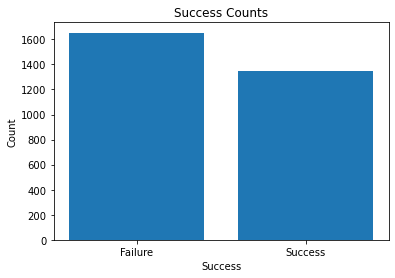

In [58]:
# Count the number of successes and failures
success_counts = comb_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

Let's look at some of the descriptive information for the combined data:

<Figure size 432x144 with 0 Axes>

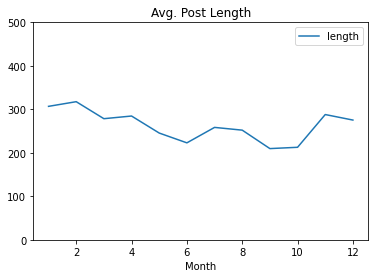

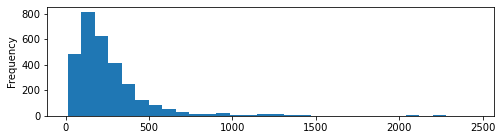

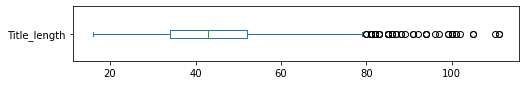

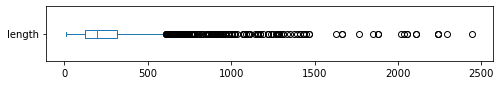

In [59]:
plot_analysis(comb_df)

In [60]:
freq_df = count_words(comb_df)
freq_df.head(5)

,freq
token,
season,9773
year,7400
mm,5500
leagu,5474
team,4665


In [61]:
#How many tokens are in the df?
len(freq_df)

10123

In [62]:
#Top words with 10+ characters
count_words(comb_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)



,freq
token,
appearances,1999
Washington,1491
organization,1080
outfielder,954
arbitration,883


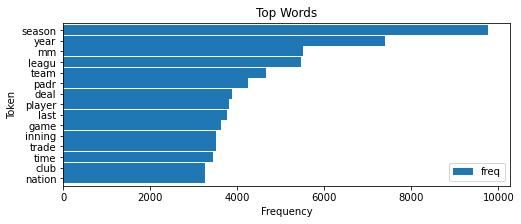

In [63]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

plt.show()

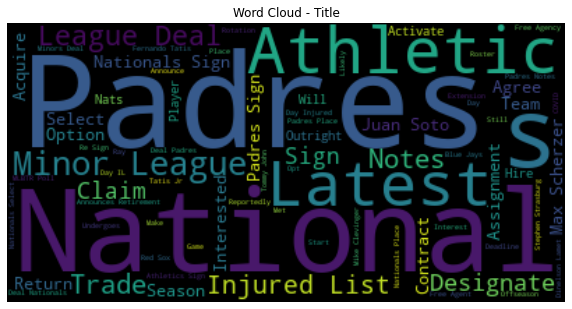

In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt   

 # Create a word cloud for the "Title" column
title_wordcloud = WordCloud().generate(' '.join(comb_df['Title'].dropna()))
plt.figure(figsize=(10, 6))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Title')
plt.show()

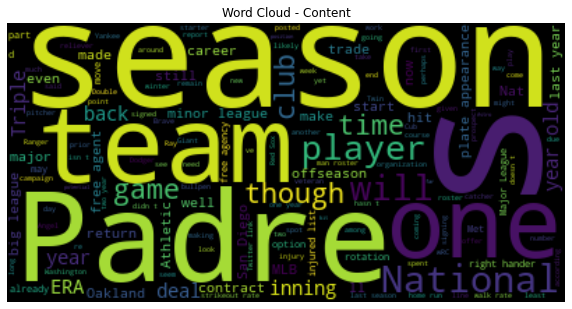

In [84]:
# Create a word cloud for the "Contents_Normalized" column
contents_wordcloud = WordCloud().generate(' '.join(comb_df['Content'].dropna()))
plt.figure(figsize=(10, 6))
plt.imshow(contents_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Content')
plt.show()

# Topic Modeling

In [88]:
stopwords = list(stopwords)  # Convert the set of stopwords to a list
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(comb_df['Content'])
tfidf_text_vectors.shape


c:\Users\earne\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(3000, 9005)

In [89]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx}:")
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        for feature, weight in zip(top_features, weights):
            print(f"{feature} ({weight})")


In [104]:
tfidf_feature_names = list(tfidf_text_vectorizer.vocabulary_.keys())
display_topics(nmf_text_model, tfidf_feature_names)



Topic 0:
dallas (0.8610168693675135)
dominguez (0.7884902644103345)
rogers (0.6279445756378046)
bagger (0.5664310518017593)
bieber (0.5321048591720876)

Topic 1:
secondly (0.45893256697555523)
likelihood (0.39856636906652676)
excellence (0.3613170753683039)
leake (0.33162086203607566)
duties (0.3035017621381586)

Topic 2:
undesirable (0.8696377272168243)
augment (0.6816127447599368)
hawks (0.585928744083907)
dragged (0.5649679918049547)
165 (0.5184656046798158)

Topic 3:
necessity (1.2710727936034616)
relatively (0.7114007964469673)
reflects (0.5794672933685406)
helps (0.4913983565621166)
447 (0.4607687797722069)

Topic 4:
tweaks (0.4945280734760777)
loyalty (0.458666409413681)
souza (0.4363806027168123)
joyce (0.43486061725626785)
deserving (0.4196492576304537)

Topic 5:
owners (1.54320516831744)
friends (0.45934485915513157)
yonhap (0.3843293637822091)
corporation (0.38348731750226855)
pedigree (0.32002301796698635)

Topic 6:
31st (0.89931673894959)
brooks (0.845654516637363)
honor 

# Modeling

## Logistic Regression Modeling

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [65]:
X_train, X_test, y_train, y_test = train_test_split(comb_df['Content'], comb_df['success'], test_size=0.2, random_state=42)


In [66]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [67]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression()

In [68]:
y_pred = model.predict(X_test_vec)

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7916666666666666


## Penalized Logistic Regression

In [70]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [71]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid_search.fit(X_train_vec, y_train)

best_C = grid_search.best_params_['C']


In [72]:
model = LogisticRegression(penalty='l2', C=best_C)
model.fit(X_train_vec, y_train)


LogisticRegression(C=10)

In [73]:
y_pred = model.predict(X_test_vec)


In [74]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.805
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       339
           1       0.78      0.77      0.77       261

    accuracy                           0.81       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.81      0.80       600



In [75]:
coefficients = model.coef_
print(coefficients)

[[ 0.04361031 -0.57810424 -0.14551028 ...  0.12073912 -0.35117841
  -0.15855351]]


In [76]:

# Retrieve feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate feature importance
feature_importance = np.abs(model.coef_[0])

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]


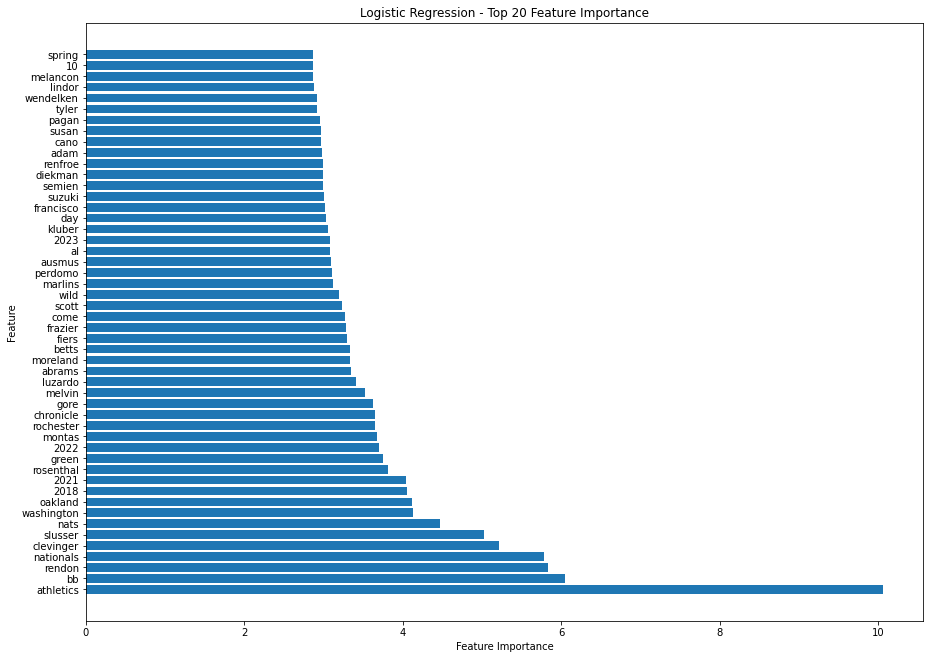

In [77]:
# Select top 20 features
top_feature_importance = sorted_feature_importance[:50]
top_feature_names = sorted_feature_names[:50]

# Plot top 20 feature importance
plt.figure(figsize=(15, 11))
plt.barh(range(len(top_feature_names)), top_feature_importance, align='center')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression - Top 20 Feature Importance')
plt.show()

# Los Angeles Dodgers Data Collection and Cleaning


In [4]:
!pip install beautifulsoup4 requests
!pip install fsspec
#Install reqired libraries
!pip install pandas
!pip install matplotlib
!pip install lxml
!pip install nltk
!pip install wordcloud
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install tqdm

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import fsspec
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import lxml

import os
import re
import numpy as np
import string
import glob
import nltk
from wordcloud import WordCloud
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
import re
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

sw = stopwords.words("english")

C:\Users\Grigor\.conda\envs\ADS_502\lib\site-packages\tensorflow\python\framework\dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [7]:
#Scrapes blog posts off of website
def scrape_website(url, file_path):
    # Send a GET request to the website
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the news article elements
    articles = soup.find_all("article")

    # Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    # Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            # Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            # Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            # Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            # Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            # Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    # Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)

    # Drop rows without content
    df.dropna()

    return df

#Initial Text Data Processing
def processing(df):
    #change the Date column to a datetime object
    df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')
    print(df.dtypes)

    print('DataFrame has', len(df), 'rows.')

    # Check for missing values
    print(df.isna().sum())

    #drop missing values
    df = df.dropna()
    
    print('The DataFrame now has', len(df), 'rows, after dropping null text rows.')
    return df

#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

#Identify noise in the text data:
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

# Plot the text length metrics
def plot_analysis(df):
    # Extract the month from the date and create a new column
    df['Month'] = df['Date'].dt.month

    # Plot the average post length
    plt.figure(figsize=(6, 2))
    df.groupby('Month').agg({'length': 'mean'}) \
        .plot(title="Avg. Post Length", ylim=(0, 500))
    plt.show()

    # Plot the post length histogram
    plt.figure(figsize=(8, 2))
    df['length'].plot(kind='hist', bins=30)
    plt.show()

    # Create a new column for title length
    df['Title_length'] = df['Title'].str.len()

    # Plot the title length box plot
    plt.figure(figsize=(8, 1))
    df['Title_length'].plot(kind='box', vert=False)
    plt.show()

    # Plot the post length box plot
    plt.figure(figsize=(8, 1))
    df['length'].plot(kind='box', vert=False)
    plt.show()

    #Word Frequency function:
    
#count words function for frequency analysis
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    #Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #Create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    #Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

#processes team data, creates binary success variable, and plots descriptive information
def team_info(df):
    # Use data only back to 2005
    df = df[df['Year'] > 2004]

    # Remove the dollar sign and comma from Est. Payroll column
    df['Est. Payroll'] = df['Est. Payroll'].replace({'\$': '', ',': ''}, regex=True)

    # Convert Est. Payroll to float
    df['Est. Payroll'] = df['Est. Payroll'].astype(float)

    # Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
    df['success'] = (df['W'] / (df['W'] + df['L']) >= 0.5).astype(int)

    # Count the number of successes and failures
    success_counts = df['success'].value_counts()

    # Create a bar plot
    plt.bar(success_counts.index, success_counts.values)
    plt.xticks(success_counts.index, ['Failure', 'Success'])
    plt.xlabel('Success')
    plt.ylabel('Count')
    plt.title('Success Counts')
    plt.show()

    # Plotting descriptive data on teams
    plt.figure(figsize=(10, 6))

    # Plotting Attendance over the years
    plt.plot(df['Year'].values, df['Attendance'].values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Attendance')
    plt.title('Home Attendance Per year')
    plt.show()

    # Plotting Wins over the years
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'].values, df['W'].values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Wins')
    plt.title('Wins per Year')
    plt.show()

    # Plotting Payroll over the years
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'].values, df['Est. Payroll'].values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Payroll')
    plt.title('Payroll of Washington Nationals over the years')
    plt.show()

    # Select numeric columns for correlation analysis
    numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
    numeric_df = df[numeric_cols]

    # Correlation matrix
    correlation = numeric_df.corr()

    # Plotting the correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # Return the modified dataframe
    return df




In [13]:
Dodgers_url = "https://www.mlbtraderumors.com/los-angeles-dodgers"
file_path = "C:/Users/Grigor/OneDrive/Desktop/Master_Program/ADS509/Project/dodgers.txt" 
#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
df = scrape_website(Dodgers_url, file_path)
df.head()

,Title,Author,Date,Content
0,Red Sox Acquire Tayler Scott From Dodgers,Darragh McDonald,"June 22, 2023",The Red Sox announced that they have acquired ...
1,MLBTR Trade Rumors Podcast: Exciting Youth Mov...,Darragh McDonald,"June 21, 2023",The latest episode of the MLB Trade Rumors Pod...
2,Dodgers Sign David Dahl To Minor League Contract,Anthony Franco,"June 20, 2023",Veteran outfielder David Dahl has signed a min...
3,Dodgers Designate Andre Jackson For Assignment,,"June 20, 2023",The Dodgers announced they’ve designated right...
4,Dodgers Select Ryan Brasier,Darragh McDonald,"June 20, 2023","5:50pm: The Dodgers have now made it official,..."


In [14]:
import pandas as pd

# URL of the webpage to scrape
Dodgers_Attendance = "https://www.baseball-reference.com/teams/LAD/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(Dodgers_Attendance)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/Grigor/OneDrive/Desktop/Master_Program/ADS509/Project/Dodgers_Attendance.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/Grigor/OneDrive/Desktop/Master_Program/ADS509/Project/Dodgers_Attendance.csv


In [15]:
path = "C:/Users/Grigor/OneDrive/Desktop/Master_Program/ADS509/Project/"

LAD_df = pd.DataFrame(pd.read_csv(path + 'Dodgers_Attendance.csv'))
LAD_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Los Angeles Dodgers,NL West,41,33,3,NaN,1728897.0,48025.0,1st of 15,"$198,971,667",101,104,Dodger Stadium
1,2022,Los Angeles Dodgers,NL West,111,51,1,Lost NLDS (3-1),3861408.0,47672.0,1st of 15,"$261,180,131",101,103,Dodger Stadium
2,2021,Los Angeles Dodgers,NL West,106,56,2,Lost NLCS (4-2),2804693.0,34626.0,1st of 15,"$248,108,334",100,103,Dodger Stadium
3,2020,Los Angeles Dodgers,NL West,43,17,1,Won WS (4-2),NaN,NaN,6th of 15,"$216,508,333",97,99,Dodger Stadium
4,2019,Los Angeles Dodgers,NL West,106,56,1,Lost NLDS (3-2),3974309.0,49066.0,1st of 15,"$193,553,333",94,97,Dodger Stadium


C:\Users\Grigor\AppData\Local\Temp\ipykernel_38812\3265831438.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].replace({'\$': '', ',': ''}, regex=True)
C:\Users\Grigor\AppData\Local\Temp\ipykernel_38812\3265831438.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].astype(float)
C:\Users\Grigor\AppData\Local\Temp\ipykernel_38812\3265831438.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

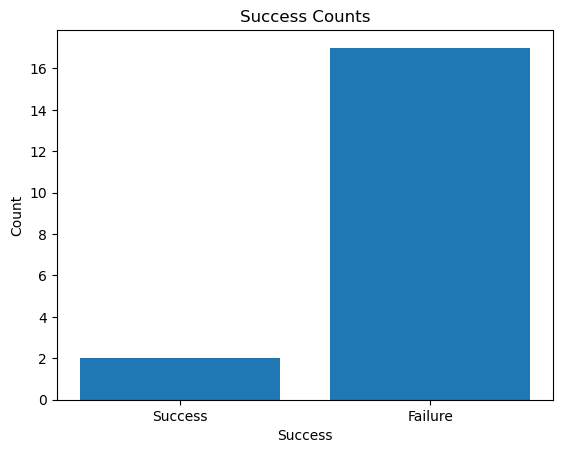

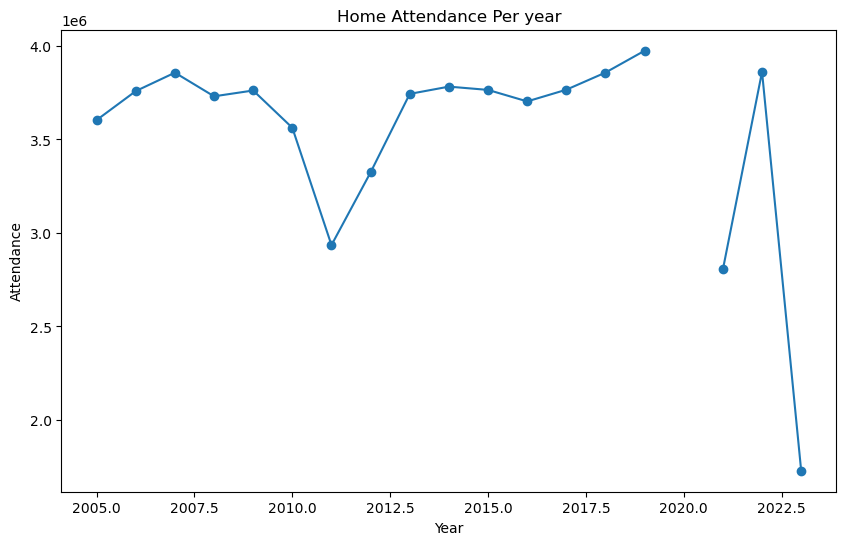

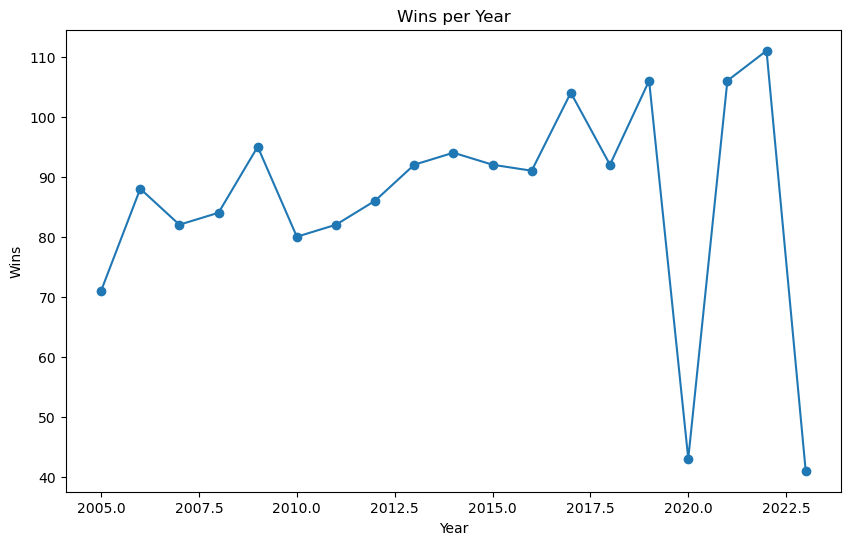

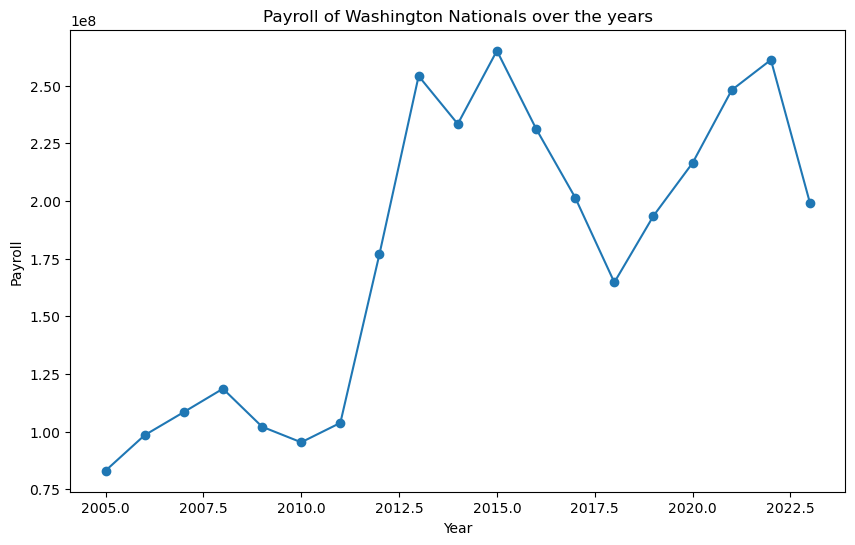

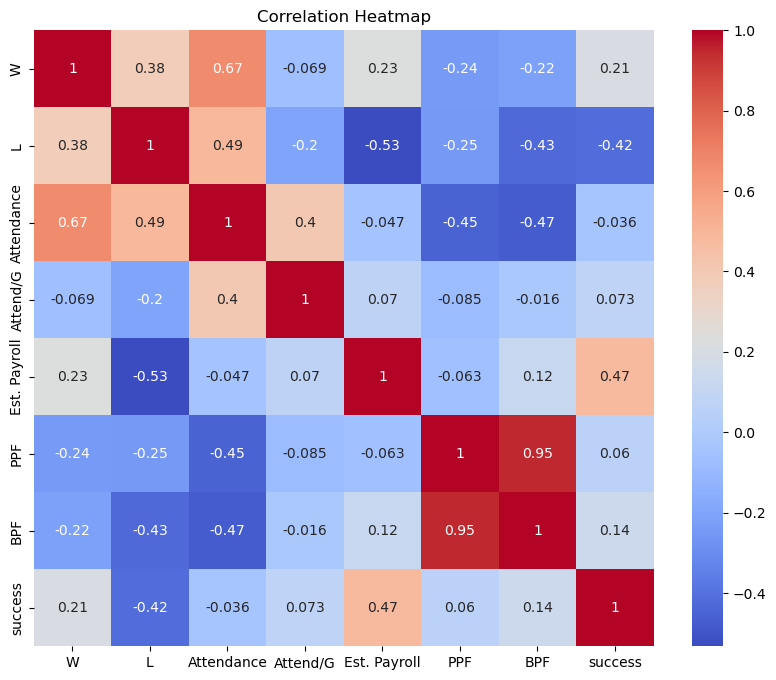

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Los Angeles Dodgers,NL West,41,33,3,NaN,1728897.0,48025.0,1st of 15,198971667.0,101,104,Dodger Stadium,1
1,2022,Los Angeles Dodgers,NL West,111,51,1,Lost NLDS (3-1),3861408.0,47672.0,1st of 15,261180131.0,101,103,Dodger Stadium,1
2,2021,Los Angeles Dodgers,NL West,106,56,2,Lost NLCS (4-2),2804693.0,34626.0,1st of 15,248108334.0,100,103,Dodger Stadium,1
3,2020,Los Angeles Dodgers,NL West,43,17,1,Won WS (4-2),NaN,NaN,6th of 15,216508333.0,97,99,Dodger Stadium,1
4,2019,Los Angeles Dodgers,NL West,106,56,1,Lost NLDS (3-2),3974309.0,49066.0,1st of 15,193553333.0,94,97,Dodger Stadium,1


In [16]:
LAD_df = team_info(LAD_df)
LAD_df.head()

In [17]:
# Extract the year from the "Date" column in df DataFrame
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Merge df and nats_df DataFrames on the "Year" column
merged_df = pd.merge(df, LAD_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_df['Year_Successful'] = merged_df['success'].fillna(0).astype(int)

merged_df.head()

C:\Users\Grigor\.conda\envs\ADS_502\lib\site-packages\pandas\core\reshape\merge.py:1204: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


,Title,Author,Date,Content,Year,success,Year_Successful
0,Red Sox Acquire Tayler Scott From Dodgers,Darragh McDonald,"June 22, 2023",The Red Sox announced that they have acquired ...,2023.0,1.0,1
1,MLBTR Trade Rumors Podcast: Exciting Youth Mov...,Darragh McDonald,"June 21, 2023",The latest episode of the MLB Trade Rumors Pod...,2023.0,1.0,1
2,Dodgers Sign David Dahl To Minor League Contract,Anthony Franco,"June 20, 2023",Veteran outfielder David Dahl has signed a min...,2023.0,1.0,1
3,Dodgers Designate Andre Jackson For Assignment,,"June 20, 2023",The Dodgers announced they’ve designated right...,2023.0,1.0,1
4,Dodgers Select Ryan Brasier,Darragh McDonald,"June 20, 2023","5:50pm: The Dodgers have now made it official,...",2023.0,1.0,1


In [18]:
len(merged_df)

40

In [19]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_df['impurity'] = merged_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
0,The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...,0.0
1,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",0.0
22,,0.0


In [20]:
# Apply normalization to the "Contents" column
merged_df["Contents_Normalized"] = merged_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_df[["Content", "Contents_Normalized"]].head()


,Content,Contents_Normalized
0,The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...,"[red, sox, announc, acquir, righthand, tayler, scott, dodger, exchang, cash, consider, scott, de..."
1,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...","[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,..."
2,"Veteran outfielder David Dahl has signed a minor league deal with the Dodgers, according to Trip...","[veteran, outfield, david, dahl, sign, minor, leagu, deal, dodger, accord, triplea, commun, dire..."
3,The Dodgers announced they’ve designated right-hander Andre Jackson for assignment. His 40-man r...,"[dodger, announc, design, righthand, andr, jackson, assign, man, roster, spot, go, righti, ryan,..."
4,"5:50pm: The Dodgers have now made it official, selecting Brasier with left-hander Bryan Hudson o...","[pm, dodger, made, offici, select, brasier, lefthand, bryan, hudson, option, righthand, andr, ja..."


In [21]:
merged_df['length'] = merged_df['Contents_Normalized'].str.len()
merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,Red Sox Acquire Tayler Scott From Dodgers,Darragh McDonald,"June 22, 2023",The Red Sox announced that they have acquired right-hander Tayler Scott from the Dodgers in exch...,2023.0,1.0,1,0.0,"[red, sox, announc, acquir, righthand, tayler, scott, dodger, exchang, cash, consider, scott, de...",192
1,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,"June 21, 2023","The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023.0,1.0,1,0.0,"[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,...",124
2,Dodgers Sign David Dahl To Minor League Contract,Anthony Franco,"June 20, 2023","Veteran outfielder David Dahl has signed a minor league deal with the Dodgers, according to Trip...",2023.0,1.0,1,0.0,"[veteran, outfield, david, dahl, sign, minor, leagu, deal, dodger, accord, triplea, commun, dire...",143
3,Dodgers Designate Andre Jackson For Assignment,,"June 20, 2023",The Dodgers announced they’ve designated right-hander Andre Jackson for assignment. His 40-man r...,2023.0,1.0,1,0.0,"[dodger, announc, design, righthand, andr, jackson, assign, man, roster, spot, go, righti, ryan,...",174
4,Dodgers Select Ryan Brasier,Darragh McDonald,"June 20, 2023","5:50pm: The Dodgers have now made it official, selecting Brasier with left-hander Bryan Hudson o...",2023.0,1.0,1,0.0,"[pm, dodger, made, offici, select, brasier, lefthand, bryan, hudson, option, righthand, andr, ja...",261


## Look at descriptive stats for text in dataframe

<Figure size 600x200 with 0 Axes>

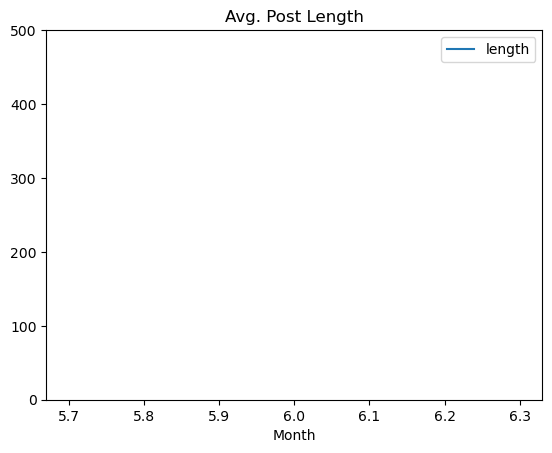

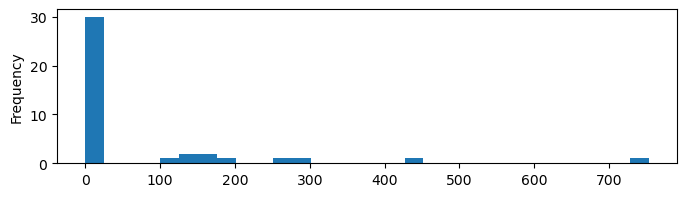

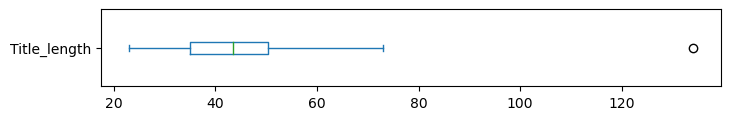

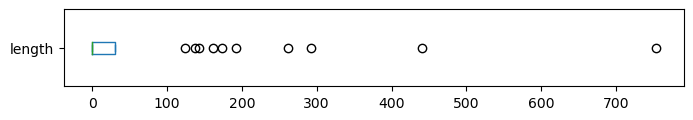

In [29]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
plot_analysis(merged_df)

In [30]:
freq_df = count_words(merged_df)
freq_df.head(5)

,freq
token,
season,46
dodger,29
leagu,27
rate,25
year,22


In [24]:
#How many tokens are in the df?
len(freq_df)

458

In [25]:
# top words with 10+ characters
count_words(merged_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


,freq
token,
assignment,11
appearances,7
throughout,6
production,6
designated,5


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

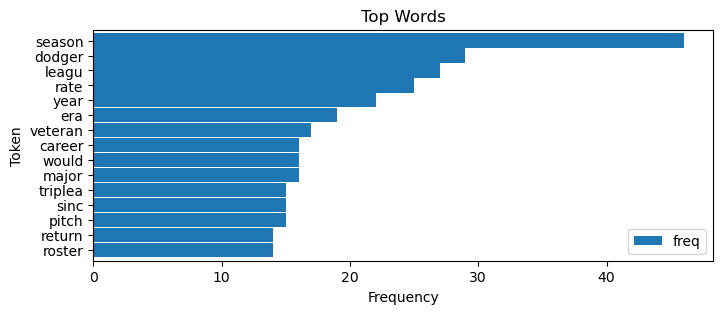

In [26]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Los Angeles Angels of Anaheim Data Collection and Cleaning

In [31]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/los-angeles-angels"
file_path = "C:/Users/Grigor/OneDrive/Desktop/Master_Program/ADS509/Project/angels.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
LAA_df = scrape_website(url, file_path)
LAA_df.head()

,Title,Author,Date,Content
0,The Silver Lining Of The Angels’ Catching Injuries,Darragh McDonald,"June 22, 2023","The Angels came into 2023 with an apparent logjam behind the plate, something that MLBTR’s Antho..."
1,Gio Urshela Unlikely To Return In 2023,,"June 21, 2023",Angels infielder Gio Urshela was placed on the injured list this week due to a pelvic fracture a...
2,Minasian: Angels’ Approach On Ohtani “Self-Explanatory”,Darragh McDonald,"June 21, 2023",Angels general manager Perry Minasian spoke to the media yesterday and was asked how the club wo...
3,Angels Select Kevin Padlo,Anthony Franco,"June 20, 2023","June 20: The Angels have officially announced the transactions, with Padlo being selected and Su..."
4,Angels Place Anthony Rendon On Injured List,Darragh McDonald,"June 19, 2023",The Angels announced that infielder Anthony Rendon has been placed on the 10-day injured list du...


In [34]:
LAA_df = processing(LAA_df)
LAA_df.head()

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object
DataFrame has 40 rows.
Title       0
Author      0
Date       30
Content     0
dtype: int64
The DataFrame now has 10 rows, after dropping null text rows.


,Title,Author,Date,Content
0,The Silver Lining Of The Angels’ Catching Injuries,Darragh McDonald,2023-06-22,"The Angels came into 2023 with an apparent logjam behind the plate, something that MLBTR’s Antho..."
1,Gio Urshela Unlikely To Return In 2023,,2023-06-21,Angels infielder Gio Urshela was placed on the injured list this week due to a pelvic fracture a...
2,Minasian: Angels’ Approach On Ohtani “Self-Explanatory”,Darragh McDonald,2023-06-21,Angels general manager Perry Minasian spoke to the media yesterday and was asked how the club wo...
3,Angels Select Kevin Padlo,Anthony Franco,2023-06-20,"June 20: The Angels have officially announced the transactions, with Padlo being selected and Su..."
4,Angels Place Anthony Rendon On Injured List,Darragh McDonald,2023-06-19,The Angels announced that infielder Anthony Rendon has been placed on the 10-day injured list du...


In [35]:
import pandas as pd

# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/ANA/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/Grigor/OneDrive/Desktop/Master_Program/ADS509/Project/Angels_Attendance.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)



Data saved to C:/Users/Grigor/OneDrive/Desktop/Master_Program/ADS509/Project/Angels_Attendance.csv


In [36]:
path = "C:/Users/Grigor/OneDrive/Desktop/Master_Program/ADS509/Project/"

angels_df = pd.DataFrame(pd.read_csv(path + 'Angels_Attendance.csv'))
angels_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Los Angeles Angels,AL West,41,35,3,NaN,1181985.0,32833.0,4th of 15,"$224,228,095",103,103,Angel Stadium of Anaheim
1,2022,Los Angeles Angels,AL West,73,89,3,NaN,2457461.0,30339.0,5th of 15,"$177,063,095",103,103,Angel Stadium of Anaheim
2,2021,Los Angeles Angels,AL West,77,85,4,NaN,1515689.0,18484.0,6th of 15,"$188,408,595",103,103,Angel Stadium of Anaheim
3,2020,Los Angeles Angels,AL West,26,34,4,NaN,NaN,NaN,8th of 15,"$181,254,762",102,101,Angel Stadium of Anaheim
4,2019,Los Angeles Angels,AL West,72,90,4,NaN,3023012.0,37321.0,2nd of 15,"$158,078,584",100,100,Angel Stadium of Anaheim


C:\Users\Grigor\AppData\Local\Temp\ipykernel_38812\3265831438.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].replace({'\$': '', ',': ''}, regex=True)
C:\Users\Grigor\AppData\Local\Temp\ipykernel_38812\3265831438.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Est. Payroll'] = df['Est. Payroll'].astype(float)
C:\Users\Grigor\AppData\Local\Temp\ipykernel_38812\3265831438.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

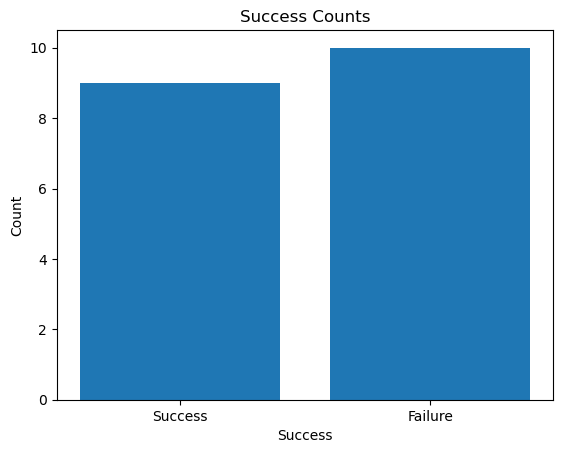

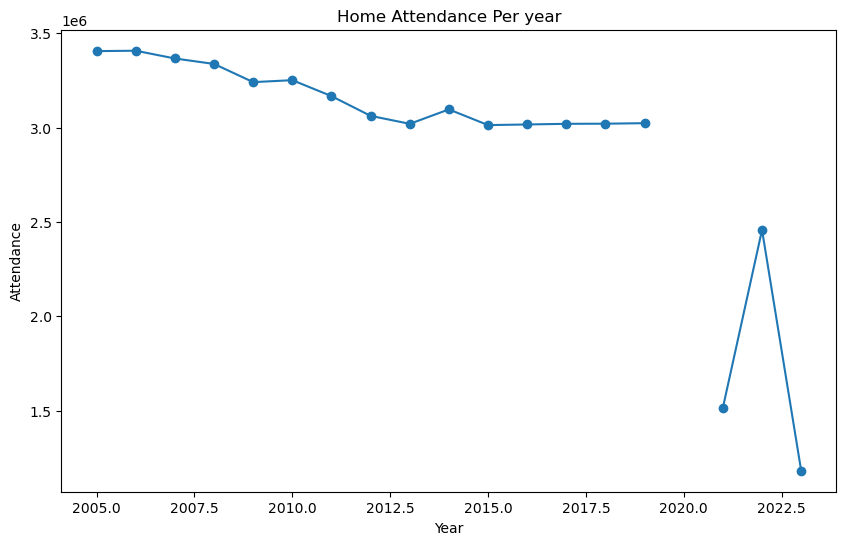

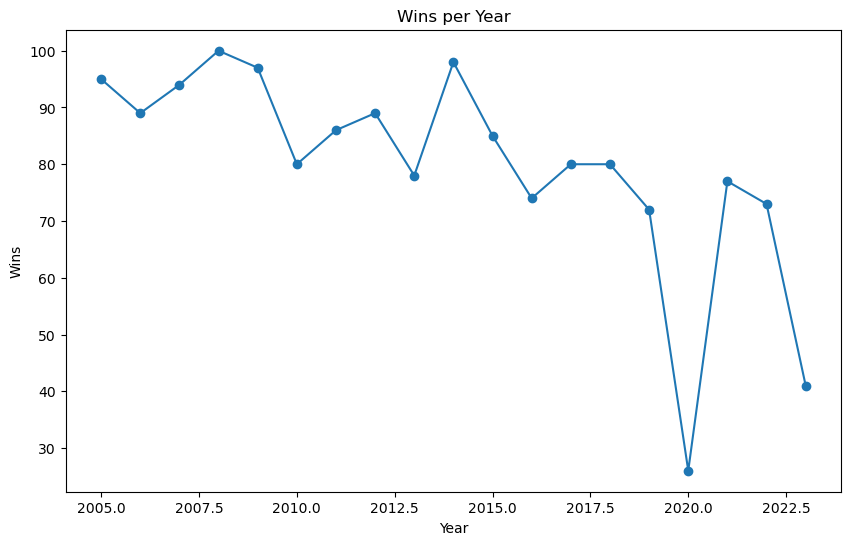

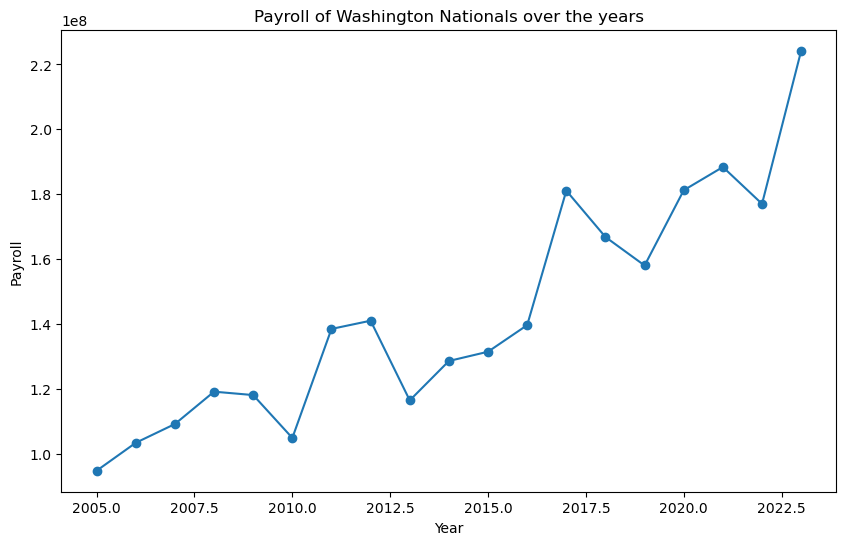

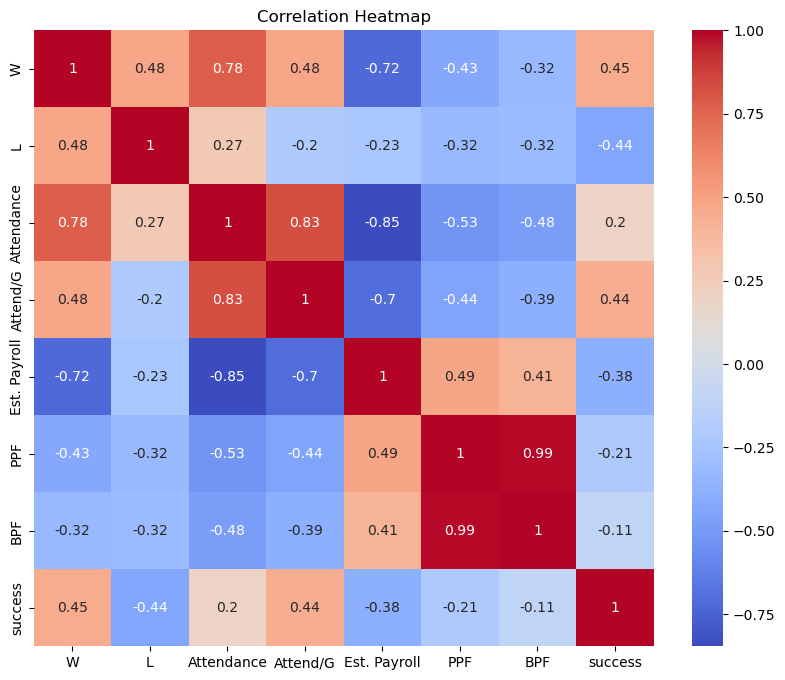

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Los Angeles Angels,AL West,41,35,3,NaN,1181985.0,32833.0,4th of 15,224228095.0,103,103,Angel Stadium of Anaheim,1
1,2022,Los Angeles Angels,AL West,73,89,3,NaN,2457461.0,30339.0,5th of 15,177063095.0,103,103,Angel Stadium of Anaheim,0
2,2021,Los Angeles Angels,AL West,77,85,4,NaN,1515689.0,18484.0,6th of 15,188408595.0,103,103,Angel Stadium of Anaheim,0
3,2020,Los Angeles Angels,AL West,26,34,4,NaN,NaN,NaN,8th of 15,181254762.0,102,101,Angel Stadium of Anaheim,0
4,2019,Los Angeles Angels,AL West,72,90,4,NaN,3023012.0,37321.0,2nd of 15,158078584.0,100,100,Angel Stadium of Anaheim,0


In [37]:
angels_df = team_info(angels_df)
angels_df.head()

In [38]:
# Extract the year from the "Date" column in df DataFrame
LAA_df['Year'] = pd.to_datetime(LAA_df['Date']).dt.year

# Merge df and pads_df DataFrames on the "Year" column
merged_laa_df = pd.merge(LAA_df, angels_df[['Year', 'success']], on='Year', how='left')

# Add a new column 'Year_Successful' based on 'success' column
merged_laa_df['Year_Successful'] = merged_laa_df['success'].fillna(0).astype(int)

merged_laa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,The Silver Lining Of The Angels’ Catching Injuries,Darragh McDonald,2023-06-22,"The Angels came into 2023 with an apparent logjam behind the plate, something that MLBTR’s Antho...",2023,1,1
1,Gio Urshela Unlikely To Return In 2023,,2023-06-21,Angels infielder Gio Urshela was placed on the injured list this week due to a pelvic fracture a...,2023,1,1
2,Minasian: Angels’ Approach On Ohtani “Self-Explanatory”,Darragh McDonald,2023-06-21,Angels general manager Perry Minasian spoke to the media yesterday and was asked how the club wo...,2023,1,1
3,Angels Select Kevin Padlo,Anthony Franco,2023-06-20,"June 20: The Angels have officially announced the transactions, with Padlo being selected and Su...",2023,1,1
4,Angels Place Anthony Rendon On Injured List,Darragh McDonald,2023-06-19,The Angels announced that infielder Anthony Rendon has been placed on the 10-day injured list du...,2023,1,1


In [39]:
len(merged_laa_df)

10

In [40]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_laa_df['impurity'] = merged_laa_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_laa_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
9,The Angels have been without starter José Suarez for a month on account of a strain in his throw...,0.001748
0,"The Angels came into 2023 with an apparent logjam behind the plate, something that MLBTR’s Antho...",0.000000
1,Angels infielder Gio Urshela was placed on the injured list this week due to a pelvic fracture a...,0.000000


In [41]:
# Apply normalization to the "Contents" column
merged_laa_df["Contents_Normalized"] = merged_laa_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_laa_df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,"The Angels came into 2023 with an apparent logjam behind the plate, something that MLBTR’s Antho...","[angel, came, appar, logjam, behind, plate, someth, mlbtr, anthoni, franco, examin, back, februa..."
1,Angels infielder Gio Urshela was placed on the injured list this week due to a pelvic fracture a...,"[angel, infield, gio, urshela, place, injur, list, week, due, pelvic, fractur, seem, like, issu,..."
2,Angels general manager Perry Minasian spoke to the media yesterday and was asked how the club wo...,"[angel, gener, manag, perri, minasian, spoke, media, yesterday, ask, club, would, approach, trad..."
3,"June 20: The Angels have officially announced the transactions, with Padlo being selected and Su...","[june, angel, offici, announc, transact, padlo, select, suarez, transfer, day, il, correspond, m..."
4,The Angels announced that infielder Anthony Rendon has been placed on the 10-day injured list du...,"[angel, announc, infield, anthoni, rendon, place, day, injur, list, due, left, wrist, contus, co..."


In [43]:
merged_laa_df['length'] = merged_laa_df['Contents_Normalized'].str.len()
merged_laa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,The Silver Lining Of The Angels’ Catching Injuries,Darragh McDonald,2023-06-22,"The Angels came into 2023 with an apparent logjam behind the plate, something that MLBTR’s Antho...",2023,1,1,0.0,"[angel, came, appar, logjam, behind, plate, someth, mlbtr, anthoni, franco, examin, back, februa...",535
1,Gio Urshela Unlikely To Return In 2023,,2023-06-21,Angels infielder Gio Urshela was placed on the injured list this week due to a pelvic fracture a...,2023,1,1,0.0,"[angel, infield, gio, urshela, place, injur, list, week, due, pelvic, fractur, seem, like, issu,...",276
2,Minasian: Angels’ Approach On Ohtani “Self-Explanatory”,Darragh McDonald,2023-06-21,Angels general manager Perry Minasian spoke to the media yesterday and was asked how the club wo...,2023,1,1,0.0,"[angel, gener, manag, perri, minasian, spoke, media, yesterday, ask, club, would, approach, trad...",435
3,Angels Select Kevin Padlo,Anthony Franco,2023-06-20,"June 20: The Angels have officially announced the transactions, with Padlo being selected and Su...",2023,1,1,0.0,"[june, angel, offici, announc, transact, padlo, select, suarez, transfer, day, il, correspond, m...",210
4,Angels Place Anthony Rendon On Injured List,Darragh McDonald,2023-06-19,The Angels announced that infielder Anthony Rendon has been placed on the 10-day injured list du...,2023,1,1,0.0,"[angel, announc, infield, anthoni, rendon, place, day, injur, list, due, left, wrist, contus, co...",271


<Figure size 600x200 with 0 Axes>

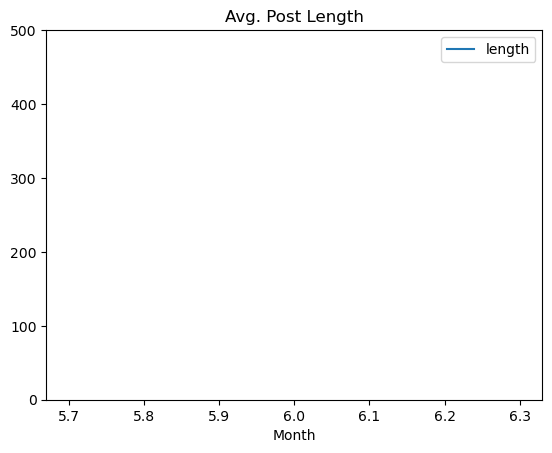

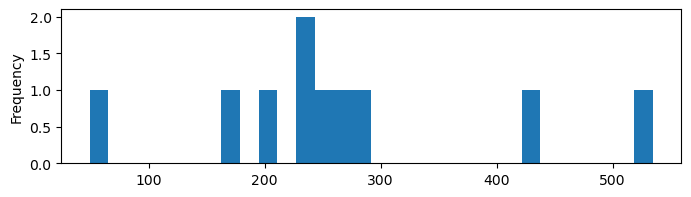

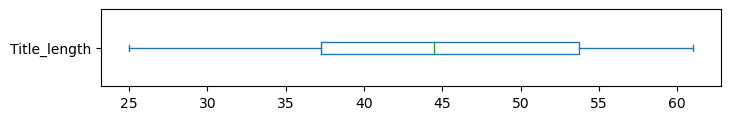

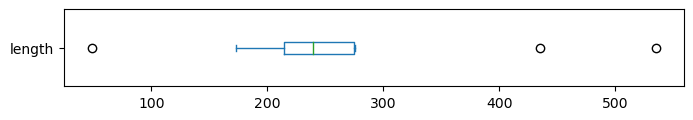

In [44]:
plot_analysis(merged_laa_df)

In [45]:
freq_df = count_words(merged_laa_df)
freq_df.head(5)

,freq
token,
year,42
leagu,34
season,32
angel,32
club,26


In [46]:
#How many tokens are in the df?
len(freq_df)

435

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

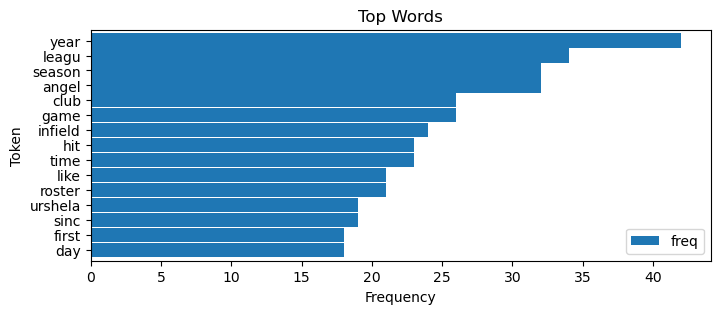

In [47]:
# top words with 10+ characters
count_words(merged_laa_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')